In [1]:
import requests
import csv
import os
import warnings
from tqdm import tqdm 
import time
from datetime import datetime
from isodate import datetime_isoformat
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
warnings.simplefilter(action='ignore', category=FutureWarning)

# ddi - Mini-Challenge zu LE3, NoSQL
Roman Studer, Simon Luder

## Use Case
<p align="center">
  <img src="./data/images/Konzept.png" alt="drawing" width="900"/>
</p>

Wir unterbreiten den Vorschlag eine NoSQL Datenbank (MongoDB) als Data Lake für die Speicherung von Time Series Daten zu verwenden und die Analyse besagter Daten auf einer Time-Series Datenbank durchzuführen. Die Analyse dieser Daten kann mittels einer auf Time Series optimierte Datenbank auf Abruf geschehen. Als Beispiel verwenden wir als Datenquelle openSenseMap, welche Messwerte und Sensormetainformationen über eine API zur Verfügung stellt. Ein aktiver Sensor sendet periodisch (je nach Sensor alle paar Sekunden oder Minuten) einen Messwert. Bei einem Intervall von 10 Sekunden sendet ein Sensor pro Jahr 3'153'600 Datenpunkte. 

OpenSenseMap erlaubt es ein ganzes Gebiet (Mittels Angabe von Breiten- und Längengrad) zu überwachen. Die Anzahl Sensoren, sowie deren Attribute kann sich über die Zeit ändern. Wenn zum Beispiel ein neuer Sensor im gleichen Gebiet in Betrieb genommen wird. Daher ist die Datenspeicherung in einer NoSQL, schemenlosen Datenbank geeignet. MongoDB ist dabei aufgrund des flexigblen Schema und einfacher horizontaler Skalierung gut geeignet. Dadurch sind wir auf Änderungen in den durch die API erhaltenen Attributen, sowie auf grosse Änderungen in der Datenmenge gewappnet. MongoDB ist allerdins nicht für die Analyse von Time Series geeignet, bzw. nicht dazu optimiert. InfluxDB, eine Time Series Datenbank, ist für Time Series Daten optimiert und kann schnell Aggregationen über eine grosse Anzahl von Datenpunkten (über Timestamp Indexiert) durchführen. Ein Beispiel wäre ein Moving Average mit kleinem Fenster über mehrere Millionen Datenpunkte.

Weiter existiert ein MongoDB-Plugin auf Telegraf welche die Performance der MongoDB überwachen kann. Somit kann das Monitoring über Influx betrieben werden. 

Im Anschluss setzen wir sowohl eine MongoDB als auch eine InfluxDB auf. Über ein Script laden wir alle Sensordaten auf dem Gelände der ETH-Zürich, welche OpenSenseMap zur Verfügung stellt für eine gewisse Zeitspanne herunter und speichern diese in der MongoDB. Im Anschluss messen wir die Zeit für Aggregationen bei steigenden Datenpunkten einzeln für beide Datenbanken. Damit können wir Unterschiede in der Performance von Influx und Mongo aufzeigen. Zum Schluss zeigen wir wie ein Punkt identifizieren werden kann ab dem es nicht mehr sinnvoll ist nur mit einer MongoDB zu arbeiten, sondern die InfluxDB zur Analyse hinzuzuziehen.

### Vergleich MongoDB vs. InfluxDB

Einen Einblick in die beiden Datenbanken zu erhalten, erlaubt das Dokument [1] "Benchmarking InfluxDB vs. MonoDB for Time Series Data, Metrics % Management" (siehe Ordner "sources"),

| Bereich  | InfluxDB  |MongoDB  | 
|---|---|---|
| **Verwendung** | Time-Series Datenbank | Dokumentenbasierte Datenbank, NoSQL Datenbank | 
| **Memory-Auslastung**  | ca 2-4 GB pro <100'000 Einträge [2]  | ca. 1 GB pro 100'000 Einträge [3] |
| **Festplattenauslastung über 24h** [1]  | 178 MB |  34820 MB  |
| **Abfragegeschwindigkeit** (Queries per Second, 1000 Einträge) [1] |  935 | 164  |
| **Einfügegeschwindigkeit** (Werte pro Sekunde) [1] | 2,800,990  | 1,114,616  |
| **Skalierbarkeit**  | Horizontal Skalierbar (Clustering) bei InfluxDB Enterprise [4] | Horizontal Skalierbar  |
| **Sicherheit**  | Authentifizierung  | Authentifizierung/Verschlüsselung  |
| **Sprache**[1]  | C/C++  | Go |
| **Schema**[1]  | Schemaless   | Schemaless |

**Verwendung:** MongoDB ist speziell für Internet- oder Business-Applikationen geeignet welche skalierbar und agil sein müssen. Da MongoDB eine Dokumentenbasierte Datenbank ist, ist sie Schemalos und kann sich somit gut an einem sich wandelnden Environment anpassen [7]. Die Influxdatenbank hingegen ist eine auf Time-Series spezialisierte Datenbank die einen Timestamp als Index verwendet. Sie ist somit für Applikationen oder System geeignet die eine hohe Anzahl von Senordaten, bzw. Log-Daten erhählt und kann schnell Aggregationen wie moving Averages erstellen. 

**Skalierbarkeit:** Die Daten in einer MongoDB sind nicht durch Relationen untereinander verbunden, sondern werden als Dokumente in einem JSON-Ähnlichen Format abgelegt. Diese Dokmente sind voneinander unabhängig, was die Verteilung über mehrere Nodes einfach ermöglicht, und somit auch das horizontale Skalieren. Vertikales Skalieren, also verfügbare Leistung der CPU oder RAM eines einzelnen Servers zu erhöhen ist ebenfalls möglich [8]. Die Enterprise Edition der InfluxDB erlaubt Clustering, wobei Data Nodes sowie Meta Nodes erstellt werden müssen. Die Meta Nodes beschreiben die Cluster, behalten im gewissen Sinne den Überblick, währenddem die Data Nodes die Daten festhalten, sowie Queries Clusterübergreigend über ein *'Protobuf'*-Protokoll druchführen [4]

**Sicherheit:** MongoDB bietet diverse Features die die Sicherheit der Datenbank erhöhen können. Die Datenbank unterstützt under anderem mehrere Authentifizierungsmechanismen wie `SCRAM` ("Salted Challenge Response Authentication Mechanism", mit SHA-1 oder SHA-256), womit Name, Passwort, Authentifizierungsdatenbank geprüft werden, aber auch das `x-509 Certificate`, die `LDAP`- und `Kerberos`-Authentifizierung. Zugriff kann durch eine rollenbasierte Zugriffskontrolle reguliert werden. So können Benutzer erstellt werden, welchen ähnlich zu einem Active Directory Rollen (wie zum Beispiel "Administrator") vergeben werden können, welche ihren Handlungsbereich einschränkt. Ein weiteres Feature ist die Client-Side Field Level Encryption. So können Felder eines Dokumentes vor der Übermittlung zum Server bereits verschlüsselt werden.(vgl. [5]) Die InfluxDB bietet ebenfalls Authentifizierungsmethoden an (darunter Authentifizierung über CLI, JWT Token oder über die API). Dabei wird ebenfalls ein Rollensystem verwendet welches die Verwaltung von Benutzern und derer Berechtigungen ermöglicht. Die Kommunikation zwischen Client und Server läuft über HTTPS, wobei die Authentizität des Servers geprüft wird. (vgl. [6])

## Datenmodell

Die verwendeten Daten sind Konzeptionell sehr einfach strukturiert. Die verwendeten Daten sind übergeordnet einer Messbox zugeordnet. Bei der Messbox sind Informationen wie der Name und die ID, aber auch der Standort anhand von Längen-, und Breitengraden angegeben. Innerhalb einer Messbox sind ein oder mehrere unterschiedliche Sensoren vorhanden.  Ein einzelner Sensor hat wieder eine eigene Bezeichnung, Sensor-ID, misst eine bestimmte Messgrösse und erstellt wiederum in regelmässigen Abständen Einträge, welche Informationen zum Messwert und dem Messzeitpunkt enthalten.

<p align="center">
  <img src="./data/images/ER-Diagram.png" alt="drawing" width="450"/>
</p>

## Load Data

In [2]:
#get list of ifu boxes at eth
url = 'https://api.opensensemap.org/boxes?'
bbox = '8.50269672304309, 47.40598032642525,  8.512126181507432, 47.4113301084323 ' # boundary box around eth zurich
boxes = requests.get(url, params={'bbox':bbox, 'full':'false'}).json()

In [3]:
from_date = '2021-05-12T10:05:49.581Z'
to_date = '2021-05-20T10:05:49.581Z'
data_format = 'csv'

In [4]:
times = pd.date_range(from_date,to_date,freq='4h')

def to_RFC3339Date(x):
    x = str(x)
    x = x.replace(' ','T')
    x = x.replace('000+00:00','Z')
    return x

times = [i for i in times][1:] # remove first time as it is equal to from_date
times = [to_RFC3339Date(i) for i in times]
len(times)

48

In [5]:
for box in tqdm(boxes):
    box_id = box['_id']
    box_name = box['name']
    location = box['currentLocation']['coordinates']
    lat, lon = location[0], location[1]
    for sensor in box['sensors']:
        try:
            sensor_id = sensor['_id']
            sensor_name = sensor['title']
            sensor_name.replace('/', '')
            sensor_unit = sensor['unit']
        except:
            pass
        
        #url = f'https://api.opensensemap.org/boxes/{box_id}/data/{sensor_id}?format={data_format}&download=true'
        url = f'https://api.opensensemap.org/boxes/{box_id}/data/{sensor_id}?from-date={from_date}&to-date={to_date}&download=true&format={data_format}'
        r = requests.get(url, stream=True)
        if (len(r.text) > 16): # check if sensor returns values (header has length 16)
            with open(f'./data/{box_name}_{sensor_name}.csv', 'wb') as f:
                for _, line in enumerate(r.iter_lines()):
                    if _ == 0: # define header
                        line = 'box_name,sensor_name,box_id,sensor_id,lat,lon,unit,current_time,value\n'
                    else:
                        timest, value = (line.decode("utf-8").split(','))
                        timest = timest.replace('T', ' ').replace('Z', '')
                        timest = datetime.strptime(timest, '%Y-%m-%d %H:%M:%S.%f').strftime('%Y-%m-%d %H:%M:%S')
                        line= f'{box_name},{sensor_name},{box_id},{sensor_id},{lat},{lon},{sensor_unit},{timest},{value}\n'
                    f.write(line.encode())

100%|██████████████████████████████████████████████████████████████████████████████████| 82/82 [03:20<00:00,  2.45s/it]


## Setup MongoDB

Dieser Abschnitt befasst sich mit dem Aufsetzen und Abfragen der Sensordaten in die MongoDB. Wir verwenden die Community Version der MongoDB. Der Installations-Wizard dafür kann unter der folgenden Adresse heruntergeladen werden: https://www.mongodb.com/try/download/community. Wenn man eine MongoDB zum Abspeichern von Zeitreihen-Daten verwenden möchte, dann gibt es mehrere Ansätze in der Struktur, die Daten organisiert werden kann. 

Wir verwenden für die MongoDB die "Single-Document" Methode werden alle Messpunkte einzeln Abgespeichert. Für jede Messung eines Sensors (oder jedes Intervall) wird also ein  eigenes Dokument in der Datenbank erstellt.
Das Dokument enthält Daten wie den Messwert, Messzeitpunkt aber auch die anderen Informationen des Sensors und der Messbox. Der Nachteil dieser Methode ist, dass grundlegende Informationen über den Sensor oder die Messbox, welche Konstant bleiben sich in jedem Dokument wiederholen, wodurch die absolute Grösse unserer Collection deutlich anwächst und die Performance der Datenbank beeinträchtigen kann. Dafür bleiben einmal erstellte Dokumente in der Datenbank unberührt und sind somit weniger anfällig für Fehler in der Datenbeschaffung.

Alternativ bestünde die Möglichkeit die Daten in einer "Time-Based bucketing" Methode in zu strukturieren. Dabei könnten zum Beispiel im Minutentakt die Messwerte aller Sensoren in einem Dokument zusammengefasst werden. Dadurch würde auch die Grösse unserer Collection kleiner. Eine Voraussetzung für diese Methode ist allerdings, dass die Sensoren im gleichen Takt oder Zeitintervall Messwerte liefern, was bei unseren Daten nicht gegeben ist. (vgl. [9])

Aus diesem Grund haben wir uns für die erste Methode entschieden, beider für jeden Messpunkt ein einzelnes Dokument erstellt wird.

### Prepare data

Die Daten sind ursprünglich als ".csv" Format vorhanden und müssen deshalb zuerst noch in eine JSON ähnliche Struktur umgewandelt werden.

In [6]:
def csv_to_dict(path, file):
    '''converts a csv file to a list of dictionaries'''
    data = pd.read_csv(path + file)
    pd.to_datetime(data.current_time, format="%Y-%m-%d %H:%M:%S")
    document = []
    for i in range(len(data)):
        dictionary = dict()
        dictionary["_id"] = file.replace('.csv', '_{}'.format(i))
        dictionary["box_name"] = data["box_name"][0]
        dictionary["sensor_name"] = data["sensor_name"][0]
        dictionary["box_id"] = data["box_id"][0]
        dictionary["sensor_id"] = data["sensor_id"][0]
        dictionary["lat"] = data["lat"][0]
        dictionary["lon"] = data["lon"][0]
        dictionary["unit"] = data["unit"][0]
        dictionary["value"] = data["value"][i]
        dictionary["timestamp"] = dt.datetime.strptime(data["current_time"][i], '%Y-%m-%d %H:%M:%S')
        document.append(dictionary)
    return document

### Create db

Der folgende Code wird verwendet, um unsere Datenbank mit dem Namen ddi_mc2 zu initialisieren. 

In [7]:
from pymongo import MongoClient
import pymongo
import datetime as dt

mongo_client = pymongo.MongoClient('localhost', 27017)
mongo_db = mongo_client["ddi_mc2"]

### Populate db

In der nächsten Zelle werden die Sensoren in die MongoDB geladen. Als erster Schritt werden alle Dokumente mit der Endung ".csv" gesucht. Ein einzelnes Dokument enthält jeweils alle Informationen inklusive der Messwerte für einen einzelnen Sensor. Danach wird jedes Dokument, mit der funktion `csv_to_dict()`, pro Zeile getrennt in ein Dictionary umgewandelt. Die Dictionaries werden dann einzeln mit dem Befehl `insert_one()` in die MongoDB geladen. 

Die Messwerte der einzelnen Sensoren sind in der MongoDB jeweils nach ihrer Zugehörigkeit zu einer Messbox, in einer Collection zusammengefasst. 

In [8]:
VERBOSE = False
path = './data/'
for file in tqdm(os.listdir("./data")):
#     print(file.split("_")[0])
    if file.endswith('.csv'): # check for filetype
        if not mongo_db[file.split("_")[0]].count_documents({"_id":file.replace('.csv', '')}) > 0:
            dictionary = csv_to_dict(path, file)
            for document in dictionary:
                mongo_db[file.split("_")[0]].insert_one(document)
            if VERBOSE:
                print("populate:", file)

100%|████████████████████████████████████████████████████████████████████████████████| 169/169 [06:17<00:00,  2.23s/it]


### List all Sensor-Boxes within the MongoDB
Mit dem Befehl list_collection_names() werden alle in der Datenbank enthaltenen Collections angezeigt. In unserem fall, entspricht das der Anzahl an Messboxen in der Datenbank.

In [9]:
mongo_db.list_collection_names()

['IfU SenseBox2021 5B',
 'IfU SenseBox 7A',
 'IfU SenseBox2021 2B',
 'IfU SenseBox2021 8B',
 'IfU SenseBox2021 04 B',
 'IfU SenseBox2021 3A',
 'IFU Sensebox2021 2A',
 'IfU SenseBox2021 7B',
 'IfU SenseBox2021 04 A',
 'IfU SenseBox2021 dab',
 'IfU SenseBox2021 1A',
 'IfU SenseBox2021 9A',
 'IfU SenseBox2021 12',
 'ifU SenseBox2021 10A',
 'IfU SenseBox2021 11A',
 'IKG Particulate Matter',
 'IfU SenseBox2021 5A']

### List all Sensors within a Collection
Nachfolgend sind alle Sensoren aufgelistet, welche in unserer Collection für die Messbox `IFU Sensebox2021 2A` enthalten sind.

In [10]:
boxes = mongo_db['IFU Sensebox2021 2A'].find().distinct('sensor_name')[0:10]
boxes

['Luftfeuchte 2-SHT31 Nr.2',
 'Luftfeuchte 2-SHT85 Nr.0',
 'Luftfeuchte 2-SHT85 Nr.1',
 'Luftfeuchte 2-SHT85 Nr.2',
 'Luftfeuchtigkeit 2-BME680',
 'Lufttemperatur 2-BME680',
 'Lufttemperatur 2-SHT31 Nr.2',
 'Lufttemperatur 2-SHT85 Nr.0',
 'Lufttemperatur 2-SHT85 Nr.1',
 'Lufttemperatur 2-SHT85 Nr.2']

### Query MongoDB

Wir fragen nun die Daten für den Sensor `Lufttemperatur 2-BME680` der Messbox `IFU Sensebox2021 2A` für unterschiedliche Zeitintervalle ab. Die Zeitintervalle beginnen bei 4 Stunden und werden Pro Iteration um 4 Stunden erhöht. Es wird deshalb erwartet, das sich die Abfragedauer pro Iteration jeweils leicht erhöht. Instesammt werden 48 unterscheidliche Zeitintervalle abgefragt, wobei die längste Zeitspanne 8 Tage beträgt. 

In [11]:
sensor_name = "Lufttemperatur 2-BME680"
box_name = "IFU Sensebox2021 2A"

mean_runtimes = []
std_runtimes = []
n_init = 5

for i in tqdm(range(len(times))):   
    runtimes = [] 
    n_datepoints = []
    
    for _ in range(n_init):

        start = time.perf_counter()

        query = list(mongo_db[box_name].aggregate([
                {
                    "$match": {
                        "sensor_name": sensor_name,
                        "timestamp": {"$gte": datetime.strptime(from_date, '%Y-%m-%dT%H:%M:%S.%fZ'), 
                                      "$lte": datetime.strptime(times[i], '%Y-%m-%dT%H:%M:%S.%fZ')}
                    }
                },
                {
                    "$group": {
                        "_id": {
                        "minute": {"$minute": "$timestamp"},
                        "hour": {"$hour": "$timestamp"},
                        "day": {"$dayOfMonth": "$timestamp"},
                        "month": {"$month": "$timestamp"},
                        "year": {"$year": "$timestamp"} 
                        }, 
                        "mean": {"$avg": "$value"},
                        "unit":{"$first": "$unit"},
                        "timestamp": { "$max": "$timestamp" }
                    }
                },
                {
                    "$project":{
                        "_id":0,
                        "mean": "$mean",
                        "unit": "$unit",
                        "timestamp_minute": {"$dateToString":{"format": "%Y-%m-%d %H:%M:00", 
                                                              "date": "$timestamp" }}
                    }
                },
                { 
                    "$sort": {
                        "timestamp_minute" : -1,
                    }
                }
            ]))

        end = time.perf_counter()

        runtimes.append(end-start)
    
    mean_runtimes.append(np.mean(runtimes))
    std_runtimes.append(np.std(runtimes))

100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:26<00:00,  1.82it/s]


Wir erhalten mit unserer Abfrage, eine Liste mit den durchschnittlichen Temperaturen pro Minute für für den Sensor: `Lufttemperatur 2-BME680`. Die Daten sind in einer Liste aus Dictionaries abgespeichert. Für eine bessere Darstellung und einfachere VIsualisierung wandeln wir die Daten noch in ein Dataframe um. 

In [12]:
plt.figure(figsize=(15,7))
df_mongodb_query = pd.DataFrame(query)
df_mongodb_query

,mean,unit,timestamp_minute
0,53.7467,°C,2021-05-20 08:51:00
1,53.6381,°C,2021-05-20 08:50:00
2,53.5088,°C,2021-05-20 08:49:00
3,53.4166,°C,2021-05-20 08:48:00
4,53.2796,°C,2021-05-20 08:46:00
...,...,...,...
9979,43.7427,°C,2021-05-12 13:47:00
9980,43.7258,°C,2021-05-12 13:46:00
9981,43.7159,°C,2021-05-12 13:45:00
9982,43.6693,°C,2021-05-12 13:44:00


<Figure size 1080x504 with 0 Axes>

## Setup InfluxDB 

Das Setup der Influx-Datenbank ist gut Dokumentiert. Möchten Sie dieses Notebook ausführen müssen sie die Datenbank installieren. Besuchen Sie dazu die Website [influxdata.com](influxdata.com) und laden Sie das auf ihr Betriebsystem passende Programm herunter. Folgen Sie für das initiale Setup den Anweisungen der Website und des Intstallationsprogramm. Um dieses Notebook auszuführen muss die Organisation "ddi" genannt werden. Weiter ist die erstellung eines sogenannten "Buckets" notwendig. Dieser kann im Influx-Dashboad unter "data -> bucket" erstellt werden. Der Bucket muss den Namen "ddi" tragen. Die Retention Policy kann auf "Never" gesetzt werden. Für die Kommunikation zur Datenbank über Python muss die Bibliothek `influxdb_client` installiert und importiert werden. Dies Bibiliothek dient als Client und ist in etwa mit dem Cursor für eine Postgres-Datenbank zu vergleichen. Beachten Sie dass der Zugriff authorisiert sein muss. Damit eine Verbindung zur Datenbank erfolgreich ist muss eine Identifikation mit einem persönlichen Token erfolgen. Dieser Token ist ebenfalls auf dem Influx-Datenbank Dashboard erhältlich unter "data -> token". Ersetzen sie den Token (Variable `token`) in der unteren Code-Zelle mit ihrem persönlichen Token   

In [13]:
# !pip install influxdb-client
from datetime import datetime

from influxdb_client import InfluxDBClient, Point, WritePrecision
from influxdb_client.client.write_api import SYNCHRONOUS

# You can generate a Token from the "Tokens Tab" in the UI
token = "uZei_UmVg7IGcllVQdvKbmbCjwx5s0pe7KfTafVspsL0qGWIg6fmB34JNwWmsEGdt9aFr2Qio6ltOB9_ZrCDDw=="
org = "ddi"
bucket = "ddi"

client = InfluxDBClient(url="http://localhost:8086", token=token)
write_api = client.write_api(write_options=SYNCHRONOUS)

# RS: uZei_UmVg7IGcllVQdvKbmbCjwx5s0pe7KfTafVspsL0qGWIg6fmB34JNwWmsEGdt9aFr2Qio6ltOB9_ZrCDDw==
# SL: AW-zLqzOTpQW4sRYaKbdXpSxBLkxT8rT-RZA-IS5MYo41RZ40YoOCoNYTyu9S2La5W4KpcDzDgCfj53fk6aZuw==

Ist die Verbindung erfolgreich, so gibt die untere Code-Zelle als Status "pass" an.

In [14]:
client.health()

{'checks': [],
 'commit': '4db98b4c9a',
 'message': 'ready for queries and writes',
 'name': 'influxdb',
 'status': 'pass',
 'version': '2.0.6'}

### Query MongoDB, insert into InfluxDB

Wir transferieren die Daten die wir für die unsere Analyse verwenden möchten in die InfluxDB indem wir die Daten für den Passenden Sensor in den Bucket "ddi" übertragen. Dazu führen wir ein Query aus welches die Daten des Sensors `IFU Sensebox20121 2A` abfragt. Dise Daten transferieren wir dann mit der `write_api()` von InfluxDB zu unserem "ddi"-Bucket.

In [15]:
col = "IFU Sensebox2021 2A"

In [16]:
sensor_names = mongo_db[col].find().distinct('sensor_name')
measurment_id = mongo_db[col].find().distinct('_id')
results = []
ts, vs = {}, {}
for j in tqdm(measurment_id):
    sample = mongo_db[col].find_one({'_id':j},{'value', 'timestamp', 'sensor_name', "box_name"})
    indlux_id = "{}_{}".format(sample["box_name"], sample["sensor_name"])
    if indlux_id not in ts.keys():
        ts[indlux_id] = []
        vs[indlux_id] = []
    ts[indlux_id].append(sample["timestamp"].strftime('%Y-%m-%d %H:%M:%S'))
    vs[indlux_id].append(sample["value"])
#       print(ts, vs)
# results[i] = dict(zip(ts, vs))


for key in ts.keys():
    result = dict()
    result["_id"] = key
    result["measurments"] = dict(zip(ts[key], vs[key]))
    results.append(result)

100%|████████████████████████████████████████████████████████████████████████| 170000/170000 [00:51<00:00, 3298.54it/s]


In [17]:
for result in tqdm(results):
    for observation in result['measurments'].items():
        point = Point(result['_id'].split('_')[0]) \
          .tag("sensor_name", result['_id'].split('_')[1]) \
          .field("_value", observation[1])\
          .time(datetime.strptime(observation[0], "%Y-%m-%d %H:%M:%S"), WritePrecision.S)

        write_api.write(bucket, org, point)

100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [02:32<00:00,  8.99s/it]


#### Query InfluxDB

Wir führen nun die selbe Afrage aus wie bei der MongoDB zuvor. Dabei nehmen wir den minütlichen Durchschnitt des Sensors "Lufttemperatur 2-BME680" der Box "IFU Sensebox2021 2A". Wir steigern mit jeder Iteration den Messbereich um vier Stunden. 

In [18]:
mean_runtimes_i = []
std_runtimes_i = []
n_init = 5

api = client.query_api()

for i in tqdm(range(len(times))):   
    runtimes = [] 
    n_datepoints = []
    
    for _ in range(n_init):

        start = time.perf_counter()

        query = f'''
            from(bucket: "{bucket}")
              |> range(start: time(v: "{from_date}"), stop: time(v: "{times[i]}"))
              |> filter(fn: (r) => r["_measurement"] == "IFU Sensebox2021 2A")
              |> filter(fn: (r) => r["_field"] == "_value")
              |> filter(fn: (r) => r["sensor_name"] == "Lufttemperatur 2-BME680")
              |> aggregateWindow(every: 1m, fn: mean, createEmpty: false)
              |> yield(name: "mean")'''

        table = api.query_data_frame(query, org=org)

        end = time.perf_counter()

        runtimes.append(end-start)
        n_datepoints.append(len(table))
    
    mean_runtimes_i.append(np.mean(runtimes))
    std_runtimes_i.append(np.std(runtimes))

100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:16<00:00,  2.84it/s]


#### Leistungsvergleich

Die folgende Grafik zeigt die Laufzeit bei steigender Anzahl Datenpunkte für eine Aggregation (Mittelwert für jede Minute) in der MongoDB sowie der InfluxDB. Wir erkennen, das die InfluxDB konstant schneller ist als die MongoDB und auch weniger variiert. 

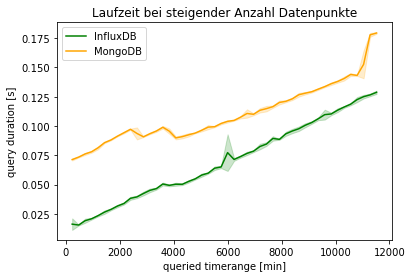

In [19]:
fmt = '%Y-%m-%dT%H:%M:%S.%fZ'
time_diff = [(datetime.strptime(i, fmt)-datetime.strptime(from_date, fmt)) for i in times]
time_diff = [time.total_seconds()/60 for time in time_diff]

plt.plot(time_diff, mean_runtimes_i, color='green', label='InfluxDB')
plt.fill_between(time_diff, np.subtract(mean_runtimes_i,std_runtimes_i), np.add(mean_runtimes_i,std_runtimes_i), alpha=.2, color='green')
plt.plot(time_diff, mean_runtimes, color='orange', label='MongoDB')
plt.fill_between(time_diff, np.subtract(mean_runtimes,std_runtimes), np.add(mean_runtimes,std_runtimes), alpha=.2, color='orange')
plt.legend()
plt.xlabel("queried timerange [min]")
plt.ylabel("query duration [s]")
plt.title('Laufzeit bei steigender Anzahl Datenpunkte')
plt.show()

### Ab wann lohnt es sich die MongoDB als Data Lake zu verwenden und die InfluxDB zur Analyse hinzuzuziehen?

Auch wenn wir es in unserem Beispiel nicht reproduzieren konnten, ist InfluxDB besser für TimeSeries Analysen geeignet als die MongoDB (vgl. [1]). Der Zeitpunkt ab dem es sich lohnt die MongoDB in Kombination mit der InfluxDB zu verwenden ist von der Anzahl Datenpunkte, der Form der Analyse und der verfügbaren Hardware abhängig. 
Um eine fundierte Entscheidung zu treffen, müssen folgende Paramter bekannt sein: 

- $n$ : Frei gewählte, minimale Anzahl Datenpunkte 
- $x$ : Anzahl Datenpunkte
- $\alpha$ : Dauer zur Ausführung eines Queries in der MongoDB für $n$ Datenpunkt
- $\beta$ : Dauer zur Ausführung eines Queries in der InfluxDB für $n$ Datenpunkt
- $\gamma$: Dauer des Datentransfers von der MongoDB zur InfluxDB bei $x$ Datenpunkten
- $a$ : Minimale Laufzeit eines Queries in der MongoDB
- $b$ : Minimale Laufzeit eines Queries in der InfluxDB


Formel zur Berechnung der Laufzeit in der MongoDB, wobei $y$ die Laufzeit darstellt:

$$
a + \alpha * x = y 
$$

Formel zur Berechnung der Laufzeit in der InfluxDB:

$$
b + \beta * x = y
$$

Basierend auf diesen beiden Formeln, können wir eine Ungleichung aufstellen die uns zeigen kann, ab wann es sich lohnt beide Datenbanken zu verwenden. Da bei der Verwendung von zwei Datenbanken zusätzlich zum Query auch noch ein Datenfransfer stattfinden muss, beziehen wir die Variable $\gamma$ mit ein. Die Formel lautet somit: 

$$
a + \alpha * x > \gamma + b + \beta * x
$$

Wobei die linke Seite die Laufzeit in der MongoDb angiebt und die rechte Seite die Laufzeit in der InfluxDB zusätzlich zur Zeit die der Datentransfer aus der MongoDB mit einnimmt. Ist nun die linke Seite grösser als die rechte Seite, lohnt sich die Verwendung der MongoDB als Data Lake in Kombination mit der InfluxDB als Analysetool.

## Erkenntnisse
Wir haben in diesem Notebook die Verwendung einer MongoDB als Data Lake in Kombination zu einer InfluxDB für Analysezwecke getestet. Dabei haben wir eine MongoDB aufgesetzt welche Sensordaten (Time Series Data) von der [opensensemap](opensensemap.org)-API erhält. Wir testen die Aggregation der Messwerte eines spezifischen Sensors über einen bestimmten Zeitraum auf der MongoDB, sowie auf der InfluxDB. Wir erkennen an der Gegenüberstellung der Resultate, das zumindest für eine Datenmenge von ca. 170'000 Messwerten die Influxdatenbank schneller ist als die MongoDB. Bei einer solchen, geringen Anzahl an Datenpunkten, hängen die Resultate stark von der momentan Auslastung des Systems ab und sind somit nicht robust. 

Wir konnten mit dieser Anzahl Datenpunkte keinen definitiven Zeitunpkt angeben, ab dem sich ein wechsel zum dualen System rechtfertigen liesse. Im vorhergehenden Abschnitt haben wir allerdings eine Formel eingeführt die Abhängig von der verwendeten Hardware und der Anzahl Datenpunkte angiebt, ob sich die Verwendung einer MongoDB in Kombination mit der InfluxDB tatsächlich lohnt.

Wir kommen zum Schluss, dass die vorgeschlagene Verwendung von MongoDB + InfluxDB erst ab einer grossen Datenmenge relevant scheint, sowie stark von folgenden Faktoren abhängt:

- Anzahl Datenpunkte
- Art der Aggregation (Moving Average, Mean etc.)
- Verfügbare Hardware 
- Netzwerkgeschwindigkeit und Banndbreite

#### Quellen

[1]«MongoDB vs InfluxDB | InfluxData Time Series Workloads», InfluxData, Dez. 18, 2018. https://www.influxdata.com/blog/influxdb-is-27x-faster-vs-mongodb-for-time-series-workloads/ (zugegriffen Juni 17, 2021).

[2]«MongoDB disk and memory requirements», Documentation & User Guides | FotoWare, Nov. 17, 2015. https://learn.fotoware.com/On-Premises/FotoWeb/05_Configuring_sites/Setting_the_MongoDB_instance_that_FotoWeb_uses/MongoDB_disk_and_memory_requirements (zugegriffen Juni 17, 2021).

[3]H. 16 A. 2018 at 12:26, «InfluxDB design guidelines to avoid performance issues», Service  Engineering (ICCLab & SPLab). https://blog.zhaw.ch/icclab/influxdb-design-guidelines-to-avoid-performance-issues/ (zugegriffen Juni 17, 2021).

[4]P. Dix, «InfluxDB Clustering - High Availability and Scalability», InfluxData, Sep. 10, 2020. https://www.influxdata.com/blog/influxdb-clustering/ (zugegriffen Juni 17, 2021).

[5]«Security — MongoDB Manual», https://github.com/mongodb/docs-bi-connector/blob/DOCSP-3279/source/index.txt. https://docs.mongodb.com/manual/security/ (zugegriffen Juni 21, 2021).

[6]«Manage InfluxDB security | InfluxDB OSS 1.8 Documentation». https://docs.influxdata.com/influxdb/v1.8/administration/security/ (zugegriffen Juni 21, 2021).

[7]«Why Use MongoDB & When to Use It?», MongoDB. https://www.mongodb.com/why-use-mongodb (zugegriffen Juni 21, 2021).

[8]«How to Scale MongoDB», MongoDB. https://www.mongodb.com/basics/scaling (zugegriffen Juni 21, 2021).

[9] «Time Series Data and MongoDB: Part 2 – Schema Design Best Practices», MongoDB, Sep. 12. 2019, https://www.mongodb.com/blog/post/time-series-data-and-mongodb-part-2-schema-design-best-practices
